License: Attribution 4.0 International (CC BY 4.0) 
https://creativecommons.org/licenses/by/4.0/

# Dating books by the names of characters
_By Danny Wolf_

Have you ever noticed that certain books have suspicously dated names? It seems that the names in a story can give hints to when the characters existed, or when the author wrote the story. Here, we use Bayes Theorem, and the `thinkbayes2` module to investigate a few fictional works. We use the [US Social Security baby name database](https://www.ssa.gov/oact/babynames/limits.html) to find the most likely year for a set of characters to coexist in the United States.

Let's get started by doing all the python imports we need.

In [30]:
from __future__ import print_function, division

% matplotlib inline

from thinkbayes2 import Hist, Pmf, Suite
import thinkplot
import math

import sys # for min float

import pandas
import glob

import warnings
warnings.filterwarnings('ignore')

### Importing the data

We use `pandas` to do all of the data mangling, here we import the name files provided by the Social Security database.

In [31]:
social_security_baby_name_files = glob.glob("names/*.txt")

all_years = {}



def get_year_from_filename(filename):
    """"""
    return int(filename.split('/')[1][3:-4], 10)

for year_filename in social_security_baby_name_files:
    year_number = get_year_from_filename(year_filename)
    all_years[year_number] = pandas.read_csv(
        year_filename,
        header=None,
        names=['Name', 'Sex', 'Count']
    )


## The Bayes part
Here, we define a `NamesInStory` class, which inherits from the `Suite` class provided by the `thinkbayes2` module. The data crunching happens in the `Likelihood` method, which is given a `hypo`thesis (the year you would find the characters to coexist in the United States, and the `data`, which is the character that you just pulled out of the story.

In order for the character to exist in the hypothesis year, we provide the character's approximate age. The `Likelihood` method subtracts the age from the current hypothesis year, and checks to see how many people were born with the name and sex of the character.

We then normalize that number with the total number of people born that year (that this database provides names of, names with less than 5 usages are taken out for anonymization purposes) to get a number approximating the name's prevalence in that hypothesis year.


In [32]:
class NamesInStory(Suite):
    def __init__(self):
        super().__init__(all_years.keys())
        self.years = list(all_years.keys())
        
    def get_bound_birth_year(self, hypo, age):
        first_year = self.years[0]
        last_year = self.years[-1]
        
        year_of_birth = hypo - age
        
        # bound to earliest year with data (reasonable guess)
        year_of_birth = max(year_of_birth, first_year)
        # bound to latest year with data
        return min(year_of_birth, last_year)

    def Likelihood(self, data, hypo):
        name, age, sex = data # unpack the given tuple
       
        # for a story to happen in the current hypothesis year,
        # the character must be born their age years before. Get that year (bound by the data we have)
        hypo_birth_year = all_years[self.get_bound_birth_year(hypo, age)]
        # normalize the probability against the current year
        # we do this
        total_people = hypo_birth_year['Count'].sum()
        people_with_name = hypo_birth_year.loc[hypo_birth_year['Name'] == name].loc[hypo_birth_year['Sex'] == sex]
        
        total_people_with_name = people_with_name['Count'].sum()
        
        probability = total_people_with_name / total_people
        if probability != 0:
            return probability
        else:
            # We don't want to ever give a 0 probability, give the closest value we know of
            return sys.float_info.min
        


## Example: Jack and Jill
The nursery rhyme "Jack and Jill" has been around for hundreds of years, and the story did not originate in the United States, but it's a good example to start out with for how the `NamesInStory` class works, and how I will use it in the next few examples.

Here, we have three instances of the `NamesInStory` class, because I want to plot each individual name alone, before combining the names together in the last graph.

We can see from the last example that the most likely year for Jack and Jill (both 10 years old) to coexist (which I am defining as when the names were both the most collectively popular), has a mean of 1970.

1970.4805246800745

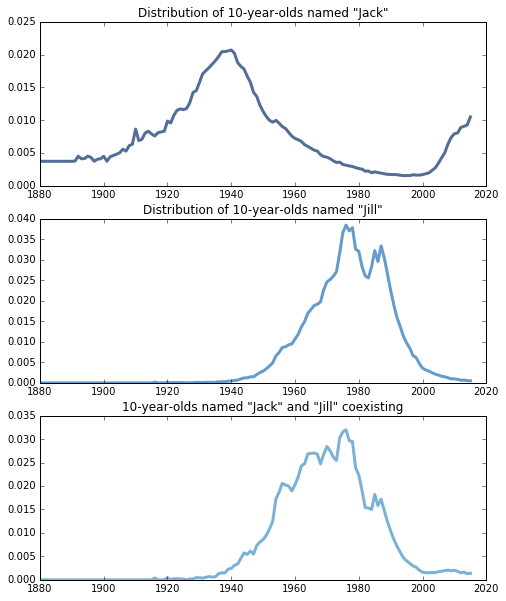

In [33]:
jack = ("Jack", 10, 'M')
jill = ("Jill", 10, 'F')

thinkplot.PrePlot(rows=3)

just_jack = NamesInStory()
just_jack.Update(jack)
thinkplot.SubPlot(1)
thinkplot.Pdf(just_jack)
thinkplot.Config(title='Distribution of 10-year-olds named "Jack"')

just_jill = NamesInStory()
just_jill.Update(jill)

thinkplot.SubPlot(2)
thinkplot.Pdf(just_jill)
thinkplot.Config(title='Distribution of 10-year-olds named "Jill"')

jack_and_jill = NamesInStory()
jack_and_jill.UpdateSet([jack, jill])
thinkplot.SubPlot(3)
thinkplot.Pdf(jack_and_jill)
thinkplot.Config(title='10-year-olds named "Jack" and "Jill" coexisting')
jack_and_jill.Mean()

## The Grapes of Wrath (1939)
Published in 1939, and with a feature film in 1940, _The Grapes of Wrath_ by John Steinbeck gained an incredible amount of attention after it was released. What I find particularly interesting is that the peak at which the names in _The Grapes of Wrath_ exist in the United States in 1958, which is when a number of characters in the book would be turning their ages in the book if they were born around 1939.

1958.611522421139

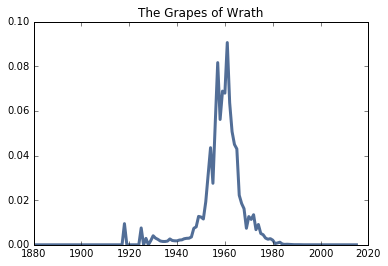

In [34]:
grapes_of_wrath = NamesInStory()

grapes_of_wrath.Update(('Thomas', 50, 'M'))
grapes_of_wrath.Update(('Thomas', 30, 'M'))
grapes_of_wrath.Update(('John', 60, 'M'))
grapes_of_wrath.Update(('Albert', 16, 'M')) # Al
grapes_of_wrath.Update(('James', 45, 'M')) # Jim, age is guess
grapes_of_wrath.Update(('Sharon', 18, 'F')) # Rose of Sharon
grapes_of_wrath.Update(('Connie', 19, 'M'))
grapes_of_wrath.Update(('Noah', 30, 'M'))
grapes_of_wrath.Update(('Ruthie', 12, 'F'))
grapes_of_wrath.Update(('Winfield', 10, 'M'))

thinkplot.Pdf(grapes_of_wrath)
thinkplot.Config(title='The Grapes of Wrath')
grapes_of_wrath.Mean()

## Harry Potter and the Sorcerer's Stone (1998)
While "Harry" and "Ronald" are names that peaked in popularity in the 40s and 50s, the addition of the names "Hermione" and "Draco" move the expected year all the way to 2014, which is the second to the last year we have data for (2015). The book series' popularity in the United States is probably to blame for the spike in recent years.

2014.2937777237116

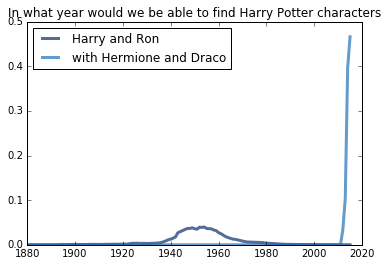

In [35]:
harry_potter_1 = NamesInStory()
harry_potter_1.UpdateSet([('Harry', 11, 'M'), ('Ronald', 11, 'M')])

thinkplot.Pdf(harry_potter_1, label='Harry and Ron')
harry_potter_1.UpdateSet([('Hermione', 11, 'F'), ('Draco', 11, 'M')])

thinkplot.Pdf(harry_potter_1, label='with Hermione and Draco')
thinkplot.Config(title='In what year would we be able to find Harry Potter characters', loc='upper left')

harry_potter_1.Mean()

## The Great Gatsby (1925)
In this example, we can see how the approach I used might break down. Because the earliest year we have data for is 1880, I use the 1880 count of names for all characters hypothesized to be born before that date. For older books, this can cause issues with the mean value of the distribution. What we can see from the plot is that most of the names were _so last century_ by the 1900s.

When we add Jordan, a 30-year-old woman in the book, we find that that name completely changes the chances of the characters coexisting from the early 1900s to 2010.

2010.9508092039016

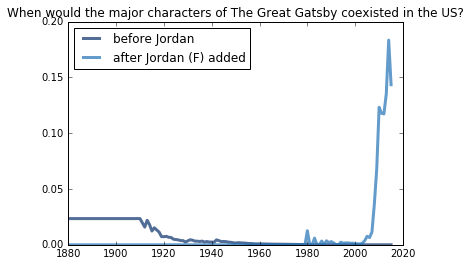

In [36]:
great_gatsby = NamesInStory()
great_gatsby.UpdateSet([
        ('Jay', 30, 'M'), 
        ('Daisy', 30, 'F'),
        ('Thomas', 30, 'M'),
        ('Nicholas', 30, 'M'),
        ('Myrtle', 30, 'F')
])
thinkplot.Pdf(great_gatsby, label='before Jordan')
great_gatsby.Update(('Jordan', 30, 'F'))
thinkplot.Pdf(great_gatsby, label='after Jordan (F) added')
thinkplot.Config(title="When would the major characters of The Great Gatsby coexisted in the US?")

great_gatsby.Mean()

## Lord of the Flies (1954)
While the _Lord of the Flies_ never specifies when the events in the book take place, we can assume, just based on the character's names we know from the book, that the book uses names common for 1942 America.

1942.231890707291

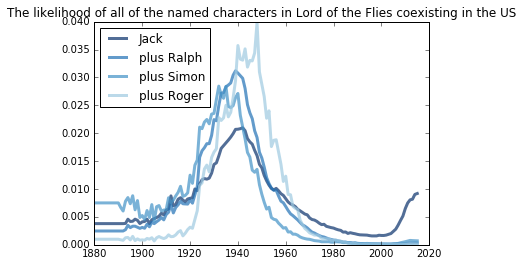

In [37]:
# Lord of the Flies (1954)
# using http://wdb.sad17.k12.me.us/teachers/bburns/com/documents/literature/lof/characters.html as a age resource
lord_of_the_flies = NamesInStory()

lord_of_the_flies.Update(('Jack', 12, 'M'))
thinkplot.Pdf(lord_of_the_flies, label='Jack')
lord_of_the_flies.Update(('Ralph', 12, 'M'))
thinkplot.Pdf(lord_of_the_flies, label='plus Ralph')
lord_of_the_flies.Update(('Simon', 10, 'M')) # Simon is younger than Ralph 
thinkplot.Pdf(lord_of_the_flies, label='plus Simon')
lord_of_the_flies.Update(('Roger', 12, 'M'))
thinkplot.Pdf(lord_of_the_flies, label='plus Roger')
thinkplot.Config(title='The likelihood of all of the named characters in Lord of the Flies coexisting in the US')

lord_of_the_flies.Mean()

## Adding Kanye to Lord of the Flies
Just for fun, I decided to add a 12-year-old boy named "Kanye" to the existing character set, just to see what happened. The results aren't too suprising.

Kanye wasn't around in the 40s.

2014.940756519655

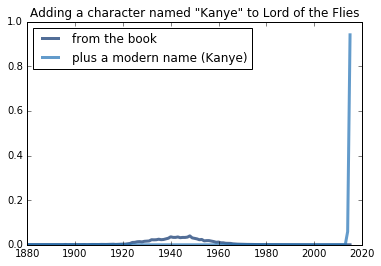

In [38]:
lord_of_the_flies = NamesInStory()
lord_of_the_flies.Update(('Jack', 12, 'M'))
lord_of_the_flies.Update(('Ralph', 12, 'M'))
lord_of_the_flies.Update(('Simon', 10, 'M')) # Simon is younger than Ralph 
lord_of_the_flies.Update(('Roger', 12, 'M'))
thinkplot.Pdf(lord_of_the_flies, label='from the book')

lord_of_the_flies.Update(('Kanye', 12, 'M'))
thinkplot.Pdf(lord_of_the_flies, label='plus a modern name (Kanye)')
thinkplot.Config(title='Adding a character named "Kanye" to Lord of the Flies', loc='upper left')

lord_of_the_flies.Mean()

## The Catcher in the Rye (1951)
I picked out a few characters from _The Catcher in the Rye_ and tested the names out. I used a histogram here, because the names "Phoebe" and "Ward" seem to be so uncommon in some years that they drop the probability of seeing these characters together in some years to 0. Again, the Social Security database drops out names that have below 5 usages, so these names might have coexisted, but the chances were very low.

Still, the `NamesInStory` class predicts 1945. Not too bad.

1945.1282505247148

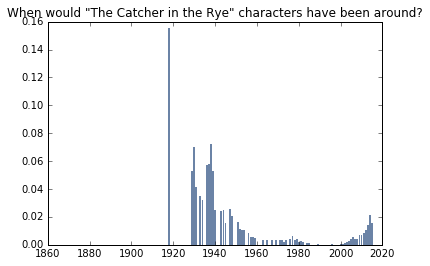

In [39]:
# The Catcher in the Rye (1951)
catcher_in_the_rye = NamesInStory()

catcher_in_the_rye.UpdateSet([
        ('Holden', 16, 'M'),
        ('Phoebe', 10, 'F'),
        ('Jane', 16, 'F'),
        ('Ward', 16, 'M')
])

mean_year = catcher_in_the_rye.Mean()

thinkplot.Hist(catcher_in_the_rye)
thinkplot.Config(title='When would "The Catcher in the Rye" characters have been around?')

mean_year

## Superman comics
I wanted to try out a series that comic book sellers would like you to believe is always happening about _now_. The last Superman movie came out this year, and the names haven't really changed since the series started.

What we find is that the debut of the original Superman comics in the 1930s is pretty close to the predicted year that `NamesInStory` predicts (1935).

1935.5322875804247

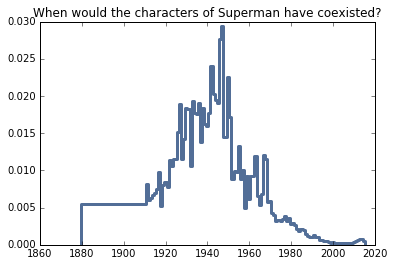

In [40]:
# Superman
superman = NamesInStory()
superman.UpdateSet([
        ('Clark', 30, 'M'), # reasonable guesses
        ('Lois', 30, 'F'),
        ('Jonathan', 65, 'M'),
        ('Martha', 65, 'F'),
        ('Perry', 55, 'M')
])

thinkplot.Pmf(superman)
thinkplot.Config(title='When would the characters of Superman have coexisted?')
superman.Mean()

## Twilight (2005)
I wanted to try a book that's distinctly modern, and the first one that came to mind was _Twilight_. After putting some of the names from the series in, I found something interesting. Stephenie Meyer, the book's author, created a number of immortal characters, and gave them names common in the year they were born, not in the year the book was supposed to take place (2005).

According to the names, the names were most common in 1898, not 2005, nowhere close to 2005.

So, I guess, if you find yourself surrounded by a set of people named "Edward", "Rosalie", "Jasper", and "Emmett", you might want to get out of town, because they're probably not teenagers.

1898.610186208203

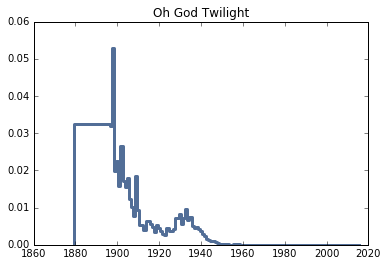

In [41]:
# Twilight (a distinctly modern book)
twilight = NamesInStory()
twilight.UpdateSet([
        ('Bella', 17, 'F'),
        ('Edward', 17, 'M'),
        ('Jacob', 16, 'M'),
        ('Rosalie', 18, 'F'),
        ('Jasper', 19, 'M'),
        ('Emmett', 20, 'M')
])

thinkplot.Pmf(twilight)
thinkplot.Config(title='Oh God Twilight')
twilight.Mean()

# The other parts of the report
HW2 problems from book: https://github.com/wolfd/ThinkBayes2/blob/master/code/HW2.ipynb